## **MLP 하이퍼파라미터 튜닝 실험** 🔍

- 다층 퍼셉트론 모델에서 주요 하이퍼파라미터 조정에 따른 성능 변화를 분석하는 실험입니다.
- 본 문서는 해당 실험의 설계, 과정 및 결과를 기술합니다.

> **평가 지표:** 테스트 정확도, 테스트 손실, 총 훈련 시간

<br>

**실험**
1. 베이스라인 구현
2. 네트워크 구조 (깊이)
3. 네트워크 구조 (너비)
4. 활성화 함수
5. 옵티마이저
6. 학습률

<br>

**사용할 데이터셋**

<img src="https://drive.google.com/uc?id=1B5vd9j6cyJ4Eopde6G--45rA0qkssmVd" width="330">

- **MNIST**: 0부터 9까지의 손글씨 숫자 이미지로 구성된 표준 데이터셋
- **구성**: 60,000개의 학습 데이터와 10,000개의 테스트 데이터
- **형식**: 각 이미지는 28×28 픽셀의 그레이스케일 형식

<br>

---

**작성자**: 2271064 한사랑

## **Import Libraries**

구현에 필요한 핵심 라이브러리를 가져오는 단계

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install torch torchvision

In [1]:
# 데이터 처리 및 수학 연산을 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms  # transforms 추가
from torchvision.transforms import ToTensor

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## **Load and Preprocess Data**
MNIST 데이터셋을 로드하고 전처리하는 단계

- **데이터 로드**: PyTorch의 datasets.MNIST 클래스를 사용하여 손글씨 숫자 이미지 데이터를 다운로드.

- **데이터 분할**: 원본 학습 데이터셋을 8:2 비율로 학습셋과 검증셋으로 나눔.

- **데이터셋 확인**: 각 데이터셋의 크기를 출력하여 확인.

### 데이터셋 로드 및 전처리

In [2]:
# -- 제공된 코드 --

# Define transformations: convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

### 데이터셋 분할 및 시각화

학습 데이터셋 크기: 48000
검증 데이터셋 크기: 12000
테스트 데이터셋 크기: 10000


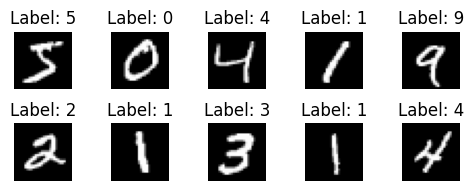

In [3]:
# 학습 데이터셋을 학습/검증 세트로 분할 (8:2 비율)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# DataLoader 생성
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 데이터셋 크기 확인
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"테스트 데이터셋 크기: {len(testset)}")

# MNIST 데이터 시각화
plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img, label = trainset[i]
    img = img.squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## **실험 1: 베이스라인 모델 (Baseline Model)**

**모델 아키텍처**는 다음과 같습니다.

- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, Sigmoid 활성화 함수
- **은닉층 2**: 32 unit, Sigmoid 활성화 함수
- **출력층**: 10 unit (0-9 class)

<br>

### 베이스라인 모델 클래스 정의

In [4]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super(BaselineMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # 시그모이드 활성화 함수
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.sigmoid(self.fc1(x))  # 첫 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc2(x))  # 두 번째 은닉층 + 활성화 함수
        x = self.fc3(x)                # 출력층
        
        return x
    
# 모델 인스턴스 생성
model = BaselineMLP().to(device)
print(model)

BaselineMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 손실 함수 및 옵티마이저 정의

In [5]:
# 손실 함수 정의 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 학습률=0.1)
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### 모델 학습 및 평가

### 학습 및 평가 함수 정의

In [ ]:
import time
from datetime import timedelta

# 학습 및 검증 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    # 결과 저장용 리스트
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # 전체 학습 시간 측정 시작
    total_start_time = time.time()
    
    print("학습 시작...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 학습 단계
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 학습 평균 손실 및 정확도 계산
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * (correct / total)
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # 검증 모드
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 단계
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # 검증 평균 손실 및 정확도 계산
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * (correct / total)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # 결과 출력
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%")
        print(f"Valid - Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%")
        print("-" * 50)
    
    # 총 학습 시간 계산 및 출력
    total_time = time.time() - total_start_time
    print(f"총 학습 시간: {str(timedelta(seconds=total_time))}")
    
    return model, train_losses, train_accs, val_losses, val_accs, total_time

### 테스트 함수 정의

In [ ]:
# 테스트 함수 정의
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * (correct / total)
    
    print("-" * 50)
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"테스트 정확도: {test_acc:.2f}%")
    
    return test_loss, test_acc

### 모델 학습 실행

In [8]:
# 모델 학습 및 평가 실행
num_epochs = 10
model, train_losses, train_accs, val_losses, val_accs, total_time = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# 테스트 세트에 대한 최종 평가
test_loss, test_acc = test_model(model, test_loader, criterion, device)

# 실험 결과 저장
baseline_results = {
    'model': 'Baseline MLP',
    'hidden_layers': '2 layers, 32 units each',
    'activation': 'Sigmoid',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'training_time': total_time
}

print("-" * 50)
print("베이스라인 모델 학습 완료!")

학습 시작...
--------------------------------------------------
Epoch [1/10]
Train - Loss: 1.5868, Accuracy: 51.22%
Valid - Loss: 0.8392, Accuracy: 80.93%
--------------------------------------------------
Epoch [2/10]
Train - Loss: 0.5794, Accuracy: 86.01%
Valid - Loss: 0.4385, Accuracy: 88.62%
--------------------------------------------------
Epoch [3/10]
Train - Loss: 0.3682, Accuracy: 90.40%
Valid - Loss: 0.3291, Accuracy: 91.24%
--------------------------------------------------
Epoch [4/10]
Train - Loss: 0.2904, Accuracy: 92.21%
Valid - Loss: 0.2759, Accuracy: 92.53%
--------------------------------------------------
Epoch [5/10]
Train - Loss: 0.2455, Accuracy: 93.41%
Valid - Loss: 0.2439, Accuracy: 93.14%
--------------------------------------------------
Epoch [6/10]
Train - Loss: 0.2141, Accuracy: 94.13%
Valid - Loss: 0.2197, Accuracy: 93.53%
--------------------------------------------------
Epoch [7/10]
Train - Loss: 0.1919, Accuracy: 94.77%
Valid - Loss: 0.2022, Accuracy: 94.1

### 베이스라인 모델 성능 시각화

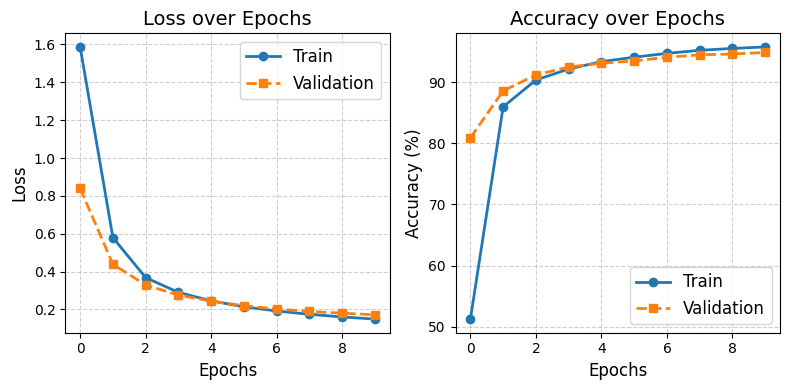

Test Accuracy: 95.11%
Test Loss: 0.1684
Training Time: 0:00:28.210183


,Model,Hidden Layers,Activation,Optimizer,Learning Rate,Test Accuracy (%),Training Time (s)
0,Baseline MLP,"2 layers, 32 units each",Sigmoid,SGD,0.1,95.11,28.21


In [20]:
# 학습 결과 시각화 함수
def visualize_training_results(results):
    plt.figure(figsize=(8, 4))
    
    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train', marker='o', markersize=6, linestyle='-', linewidth=2)
    plt.plot(results['val_losses'], label='Validation', marker='s', markersize=6, linestyle='--', linewidth=2)
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accs'], label='Train', marker='o', markersize=6, linestyle='-', linewidth=2)
    plt.plot(results['val_accs'], label='Validation', marker='s', markersize=6, linestyle='--', linewidth=2)
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # 테스트 결과 출력
    print(f"Test Accuracy: {results['test_acc']:.2f}%")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Training Time: {timedelta(seconds=results['training_time'])}")

# 베이스라인 모델 학습 결과 시각화
visualize_training_results(baseline_results)

# 성능 요약 표시
performance_summary = {
    'Model': [baseline_results['model']],
    'Hidden Layers': [baseline_results['hidden_layers']],
    'Activation': [baseline_results['activation']],
    'Optimizer': [baseline_results['optimizer']],
    'Learning Rate': [baseline_results['learning_rate']],
    'Test Accuracy (%)': [f"{baseline_results['test_acc']:.2f}"],
    'Training Time (s)': [f"{baseline_results['training_time']:.2f}"]
}

# 결과 표 생성
import pandas as pd
summary_df = pd.DataFrame(performance_summary)
display(summary_df)